# Método de Holt de dos parámetros

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importamos los datos en un dataframe
df=pd.read_csv("dataframe.csv",header=0)

In [3]:
#definimos una función que formatea nuestro df
def prepararDf(dataframe):
    df=dataframe.copy()
    df.index+=1
    df.columns = ['periodo','Y(t)']
    df['t'] = df.index
    return df

df=prepararDf(df)
df.head()

,periodo,Y(t),t
1,1,1.3660,1
2,2,1.4066,2
3,3,1.7025,3
4,4,1.6233,4
5,5,1.6970,5


# Método

In [4]:
#Función del formato de tabla del método
def calcularValoresHolt(dataframe,alfa=0.5,beta=0.5):
    df = dataframe.copy()
    #print(df.head())
    # Preparación de columnas
    df['A(t)'] = np.NaN
    df['T(t)'] = np.NaN
    

    # Inicializar valores iniciales del método 
    Y1 = df.loc[1,'Y(t)'] 
    df.loc[1,'A(t)'] = Y1
    df.loc[1,'T(t)'] = 0


    inicio = df['A(t)'].last_valid_index() + 1
    #print(df.head())
    for t in range(inicio, df.shape[0]+1):
        Yt = df.loc[t, 'Y(t)']

        # cálculo A(t)
        At_1 = df.loc[t-1, 'A(t)']
        Tt_1 = df.loc[t-1, 'T(t)']
        At = alfa*Yt + (1-alfa)*(At_1+Tt_1)
        df.loc[t, 'A(t)'] = At

        # cálculo T(t)
        Tt = beta*(At - At_1) + (1 - beta)*Tt_1
        df.loc[t, "T(t)"] = Tt    
    
    return df

df=calcularValoresHolt(df)
df.tail()

,periodo,Y(t),t,A(t),T(t)
44,44,2.009,44,1.911657,-0.006489
45,45,1.775,45,1.840084,-0.039031
46,46,2.205,46,2.003027,0.061956
47,47,1.973,47,2.018991,0.038960
48,48,1.655,48,1.856476,-0.061778


In [5]:
#Funcion de pronostico
def pronosticoHolt(dataframe,numPronosticos=3):
    df = dataframe.copy()
    df['p'] = np.NaN
    df['F(t+p)'] = np.NaN
    inicio = df['Y(t)'].first_valid_index()+1 
    df.loc[inicio:df.shape[0],'p'] = 1 # inicia p en 1
    # ciclo de pronostico para los renglones con valor en Y(t) 
    for t in range(inicio,df.shape[0]): 
        At = df.loc[t, 'A(t)']
        p = df.loc[t, 'p']
        Tt = df.loc[t,'T(t)']

        Ftp = At + p*Tt

        df.loc[t+p, 'F(t+p)'] = Ftp
    
    #Inicio de ciclo para pronosticar tiempos adelante
    At = df.loc[t+1, 'A(t)']
    Tt = df.loc[t+1,'T(t)']
    final=df.shape[0]

    for t in range(final, final+numPronosticos):
        Ftp = At + p*Tt
        df.loc[t+1, 'F(t+p)'] = Ftp

        p+=1
        df.loc[t+1,'t']=t+1
        if p!=numPronosticos+1:
            df.loc[t+1,'p']=p

        
    return df

df=pronosticoHolt(df)
df.tail()

,periodo,Y(t),t,A(t),T(t),p,F(t+p)
47,47.0,1.973,47.0,2.018991,0.038960,1.0,2.064982
48,48.0,1.655,48.0,1.856476,-0.061778,1.0,2.057951
49,NaN,NaN,49.0,NaN,NaN,2.0,1.794698
50,NaN,NaN,50.0,NaN,NaN,3.0,1.732920
51,NaN,NaN,51.0,NaN,NaN,NaN,1.671143


# Errores

In [6]:
def calcularErrores(dataframe):
    df = dataframe.copy()
    df['e(t)'] = np.NaN
    df['|e(t)|'] = np.NaN
    df['e(t)^2'] = np.NaN
    df['|e(t)|/Y(t)'] = np.NaN

    inicio=df['F(t+p)'].first_valid_index()
    final=df['Y(t)'].last_valid_index()+1

    for i in range(inicio,final):
        Yt = df.loc[i]['Y(t)']
        pron = df.loc[i]['F(t+p)']
        et = Yt - pron
        et_abs = np.abs(et)

        df.loc[i, 'e(t)'] = et
        df.loc[i, '|e(t)|'] = et_abs
        df.loc[i, 'e(t)^2'] = et**2
        df.loc[i, '|e(t)|/Y(t)'] = et_abs/Yt

    errores = {
    'DAM': np.mean(df['|e(t)|']),
    'EMC': np.mean(df['e(t)^2']),
    'PEMA': np.mean(df['|e(t)|/Y(t)'])*100,
    }
    df_errores = pd.DataFrame(errores,index=['Errores:'])
    return df,df_errores

df,df_errores=calcularErrores(df)
print(df.tail())
print(df_errores.head())

    periodo   Y(t)     t      A(t)      T(t)    p    F(t+p)      e(t)  \
47     47.0  1.973  47.0  2.018991  0.038960  1.0  2.064982 -0.091982   
48     48.0  1.655  48.0  1.856476 -0.061778  1.0  2.057951 -0.402951   
49      NaN    NaN  49.0       NaN       NaN  2.0  1.794698       NaN   
50      NaN    NaN  50.0       NaN       NaN  3.0  1.732920       NaN   
51      NaN    NaN  51.0       NaN       NaN  NaN  1.671143       NaN   

      |e(t)|    e(t)^2  |e(t)|/Y(t)  
47  0.091982  0.008461     0.046621  
48  0.402951  0.162370     0.243475  
49       NaN       NaN          NaN  
50       NaN       NaN          NaN  
51       NaN       NaN          NaN  
               DAM       EMC      PEMA
Errores:  0.152377  0.038806  8.439674


# Gráfica

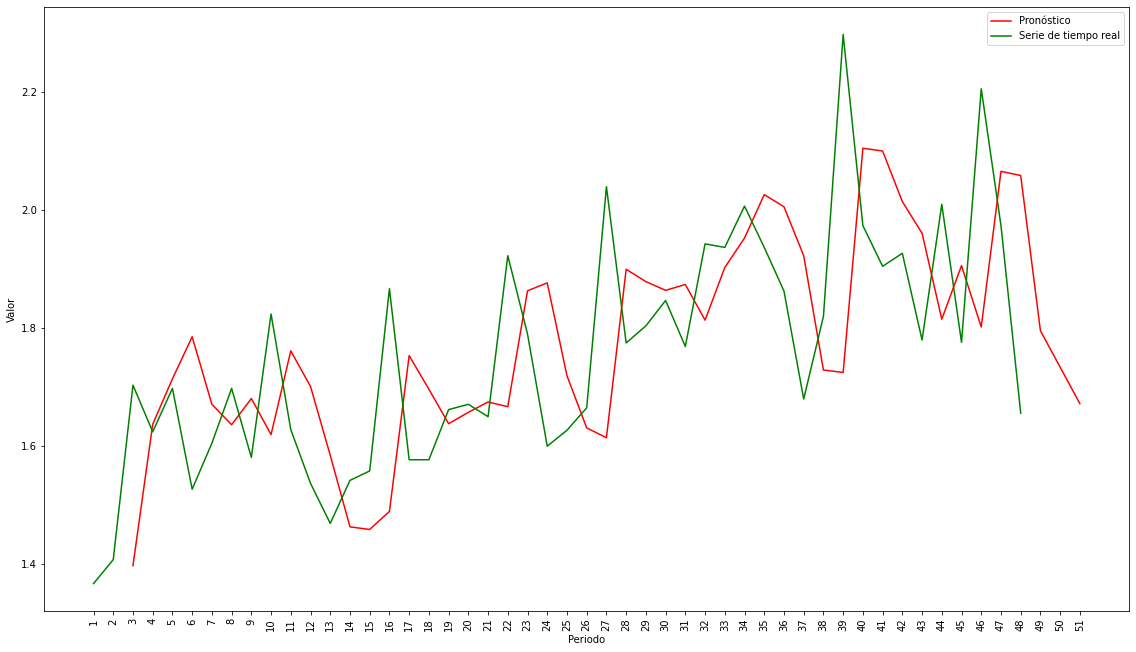

In [7]:
def pintarGrafico(dataframe,ancho=1400,alto=800):
    df=dataframe
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    plt.subplots(figsize=(ancho*px, alto*px))

    # Labels (etiquetas) de ejes x, y
    plt.ylabel('Valor')
    plt.xlabel('Periodo')

    # Puntos, pares ordenados que se calcularon como pronóstico
    plt.plot(
        df['t'], df['F(t+p)'], '-',
        label='Pronóstico',
        color='r'
    )

    # Puntos, pares ordenados que se proporcionaron como datos muestra
    plt.plot(
        df['t'], df['Y(t)'], '-',
        label='Serie de tiempo real',
        color='g'
    )
    
    plt.legend(loc='best')
    plt.xticks(df.index,rotation=90)
    plt.show()

pintarGrafico(df)

# Pronosticos en las series de tiempo del proyecto:

In [8]:
#Función para ejecutar método en un df completo
def aplicarMetodo(pathArchivocsv,alfa=0.5,beta=0.5,numPronosticos=3):
    df=pd.read_csv(pathArchivocsv,header=0)
    df=prepararDf(df)
    df=calcularValoresHolt(df,alfa,beta)
    df=pronosticoHolt(df,numPronosticos)
    df,df_errores=calcularErrores(df)
    return df,df_errores

# Método con mejor PEMA

In [9]:
# función que pruebas todas las alfa y beta
# Fuerza bruta, nada optimo
def aplicarMetodoOptimizado(pathArchivocsv,numPronosticos=3):
    df=pd.read_csv(pathArchivocsv,header=0)
    df=prepararDf(df)
    PEMAmejor=100.0
    inicio=0.001
    fin=0.9999
    paso=0.05
    for alfa in np.arange(inicio,fin,paso):
        for beta in np.arange(inicio,fin,paso):
            df2=calcularValoresHolt(df,alfa,beta)
            df2=pronosticoHolt(df2,numPronosticos)
            df2,df_errores=calcularErrores(df2)
            PEMA = df_errores.loc['Errores:','PEMA']
            if PEMA<PEMAmejor:
                dfMejor=df2.copy()
                df_erroresMejor=df_errores.copy()
                PEMAmejor=PEMA
                alfaMejor=alfa
                betaMejor=beta
    df_erroresMejor['alfa']=[alfaMejor]
    df_erroresMejor['beta']=[betaMejor]        
    return dfMejor,df_erroresMejor

    periodo   Y(t)     t      A(t)      T(t)    p    F(t+p)      e(t)  \
47     47.0  1.973  47.0  1.970744  0.000589  1.0  1.969988  0.003012   
48     48.0  1.655  48.0  1.891933  0.000510  1.0  1.971333 -0.316333   
49      NaN    NaN  49.0       NaN       NaN  2.0  1.892443       NaN   
50      NaN    NaN  50.0       NaN       NaN  3.0  1.892952       NaN   
51      NaN    NaN  51.0       NaN       NaN  NaN  1.893462       NaN   

      |e(t)|    e(t)^2  |e(t)|/Y(t)  
47  0.003012  0.000009     0.001527  
48  0.316333  0.100066     0.191138  
49       NaN       NaN          NaN  
50       NaN       NaN          NaN  
51       NaN       NaN          NaN  
               DAM       EMC      PEMA   alfa   beta
Errores:  0.118036  0.026469  6.489296  0.251  0.001


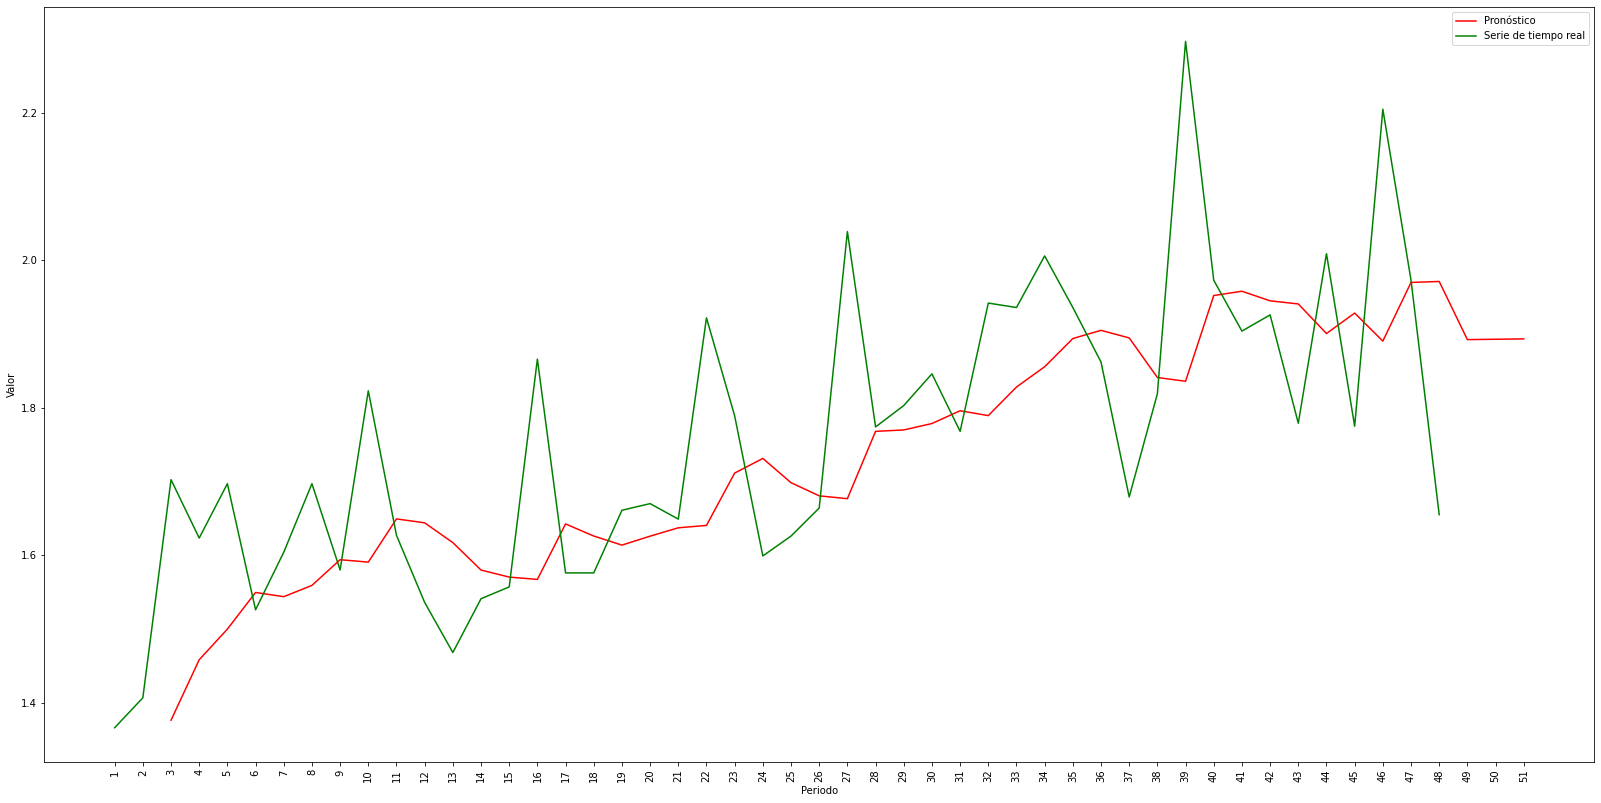

In [10]:
# Serie de ejemplo
dfserie,dfserie_errores = aplicarMetodoOptimizado("dataframe.csv")
print(dfserie.tail())
print(dfserie_errores)
pintarGrafico(dfserie,2000,1000)